In [1]:
include("../model/sepsis_types.jl")
using .SepsisTypes
include("../model/sepsis_gen.jl")
using .Sepsis
include("../model/inference.jl")
using .Inference
include("../model/softmax.jl")
using .Softmax
include("../model/smart.jl")
using .Smart
include("../value_iter.jl")
using .ValueIteration
using Revise
using PyCall;
using Gen;
using CairoMakie
sepsis_gym = pyimport("custom_sepsis");
np = pyimport("numpy");
using BenchmarkTools
using Serialization

LoadError: LoadError: PyError (PyImport_ImportModule

The Python package custom_sepsis could not be imported by pyimport. Usually this means
that you did not install custom_sepsis in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/Users/luisastue/miniconda3/bin/python3.10

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the custom_sepsis module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the PyCall documentation,
set ENV["PYTHON"]="", run Pkg.build("PyCall"), and re-launch Julia. Then,
To install the custom_sepsis module, you can use `pyimport_conda("custom_sepsis", PKG)`,
where PKG is the Anaconda package that contains the module custom_sepsis,
or alternatively you can use the Conda package directly (via
`using Conda` followed by `Conda.add` etcetera).

) <class 'ModuleNotFoundError'>
ModuleNotFoundError("No module named 'custom_sepsis.models.dirichlet.model.tr_gym'")
  File "/Users/luisastue/thesis/hc-rl-thompson-sampling/sepsis/custom_sepsis/src/custom_sepsis/__init__.py", line 2, in <module>
    from .models import *
  File "/Users/luisastue/thesis/hc-rl-thompson-sampling/sepsis/custom_sepsis/src/custom_sepsis/models/__init__.py", line 1, in <module>
    from .dirichlet import *
  File "/Users/luisastue/thesis/hc-rl-thompson-sampling/sepsis/custom_sepsis/src/custom_sepsis/models/dirichlet/__init__.py", line 1, in <module>
    from .evaluate import *
  File "/Users/luisastue/thesis/hc-rl-thompson-sampling/sepsis/custom_sepsis/src/custom_sepsis/models/dirichlet/evaluate/__init__.py", line 2, in <module>
    from .thompson_sampling import *
  File "/Users/luisastue/thesis/hc-rl-thompson-sampling/sepsis/custom_sepsis/src/custom_sepsis/models/dirichlet/evaluate/thompson_sampling.py", line 1, in <module>
    from ..model import Policy, DirModel, FullModel, compress_array, decompress_array, n_states, n_actions, compress_policy, decompress_policy
  File "/Users/luisastue/thesis/hc-rl-thompson-sampling/sepsis/custom_sepsis/src/custom_sepsis/models/dirichlet/model/__init__.py", line 1, in <module>
    from .tr_gym import *

in expression starting at /Users/luisastue/thesis/hc-rl-thompson-sampling/sepsis/custom_sepsis/src/custom_sepsis/models/ppl/model/sepsis_gen.jl:3

In [2]:
mutable struct History
    choices::ChoiceMap
    policies::Vector{Policy}
    start_states::Vector{State}
    index::Int
    params::Dict
    scores::Dict
    acceptance::Dict
    sampled_params::Dict
    mean_rewards::Dict

    function History()
        return new(choicemap(), [], [], 0, Dict(), Dict(), Dict(), Dict(), Dict())
    end
end;


In [3]:

function load_history(name::String)::History
    # Implement loading from file, e.g., using Serialization
    open(name, "r") do io
        return deserialize(io)
    end
end

load_history (generic function with 1 method)

In [10]:
history = load_history("data/mcmc/history-detailed.jld")

History(DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:episodes => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(5 => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:trajectory => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(5 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => NORMAL, :bp => HIGH, :glu => SUPER_HIGH), Dict{Any, Any}()), 4 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => NORMAL, :bp => HIGH, :glu => HIGH), Dict{Any, Any}()), 6 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => HIGH, :bp => HIGH, :glu => HIGH), Dict{Any, Any}()), 2 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => NORMAL, :bp => HIGH, :glu => NORMAL), Dict{Any, Any}()), 3 => DynamicChoiceMap(Dict{Any, Any}(:o2 => LOW, :hr => NORMAL, :bp => NORMAL, :glu => HIGH), Dict{Any, Any}()), 1 => DynamicChoiceMap(Dict{Any, Any}(:o2 => NORMAL, :hr => NORMAL, :bp => HIGH, :glu => NORMAL), Dict{Any, Any}()))))), 56 => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:traject

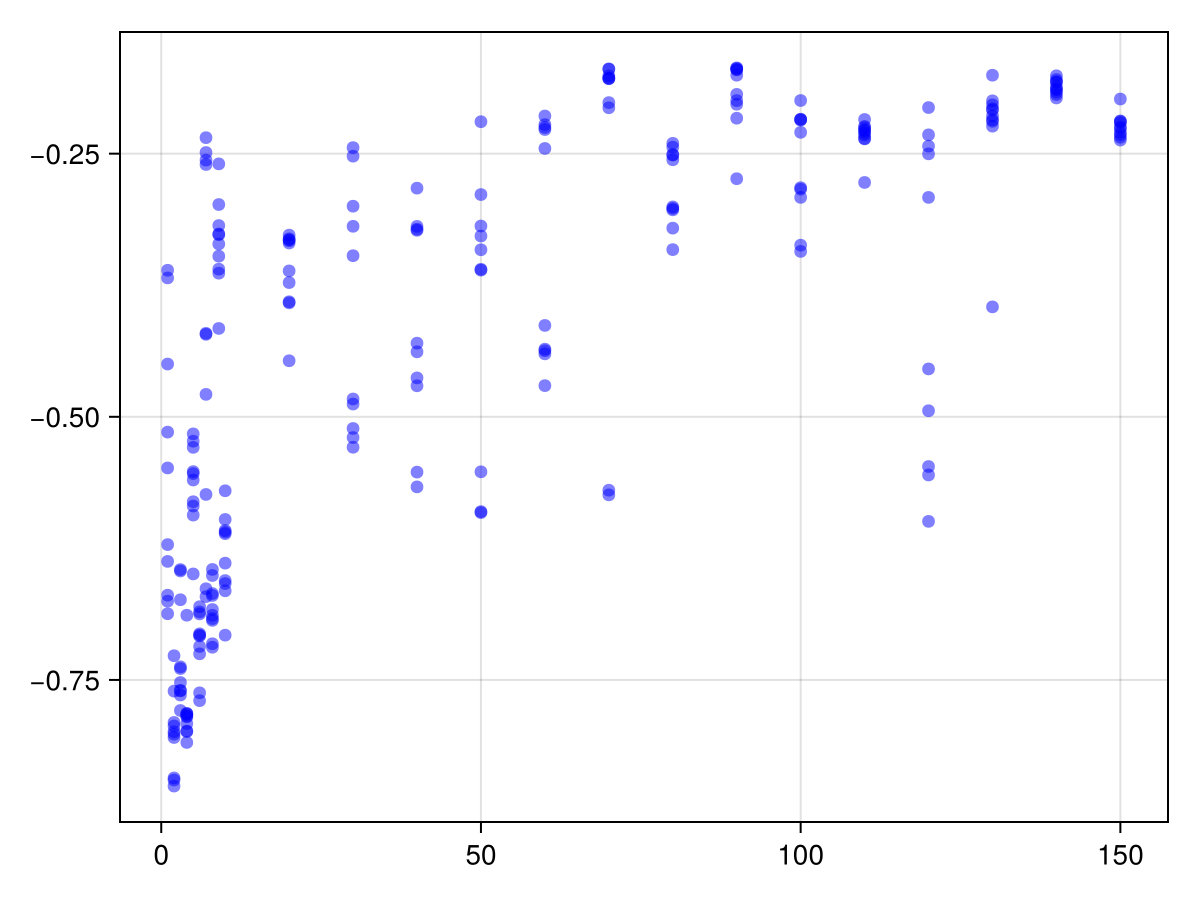

In [11]:

fig = Figure()
ax = Axis(fig[1, 1])

for i in 1:10
    ks = sort(collect(keys(history.mean_rewards)))
    plot!(ax, ks, [history.mean_rewards[k][i] for k in ks], alpha=0.5, color="blue")
end

# ax.xscale = log2
fig


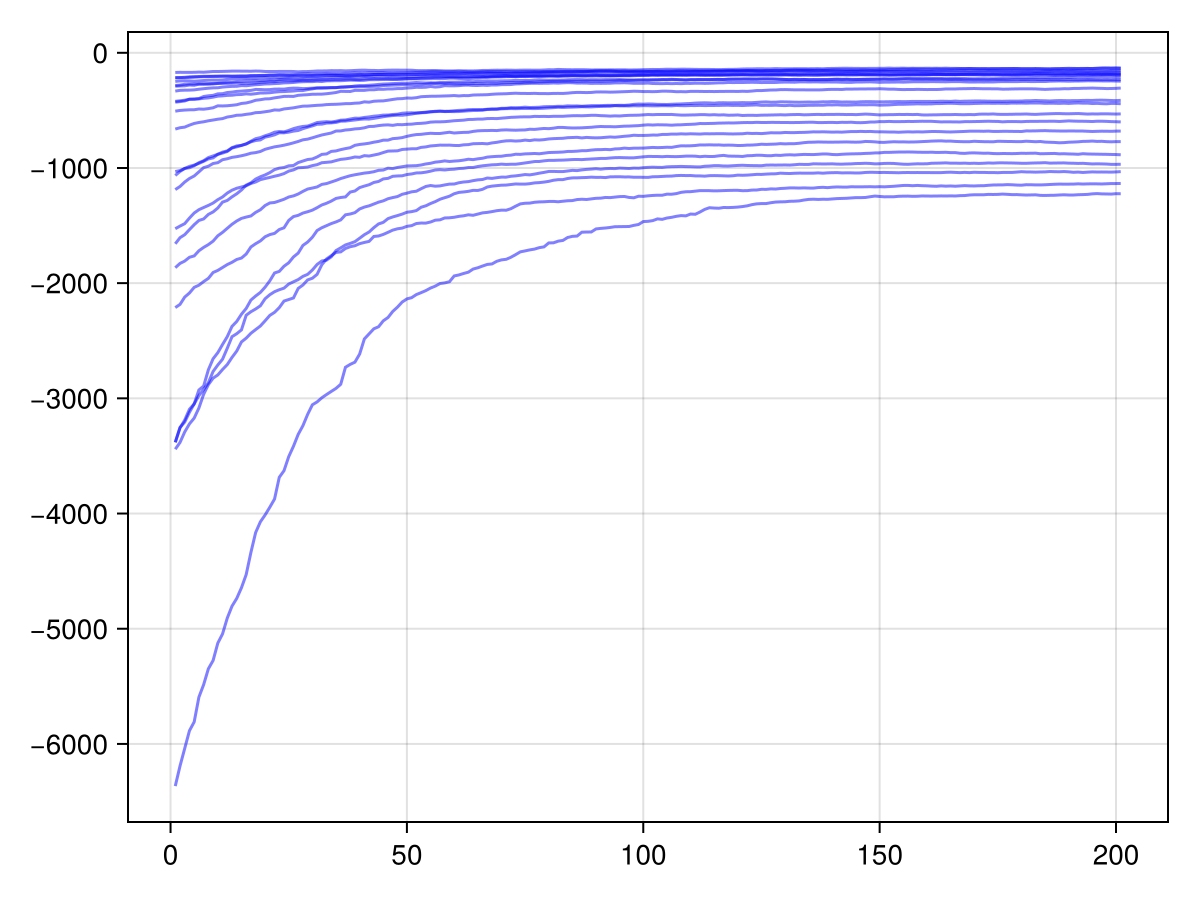

In [32]:
keys = sort(collect(keys(history.scores)))
fig = Figure()
ax = Axis(fig[1, 1])

for k in keys
    lines!(ax, history.scores[k], color="blue", alpha=0.5)
end


# ax.xscale = log2
fig


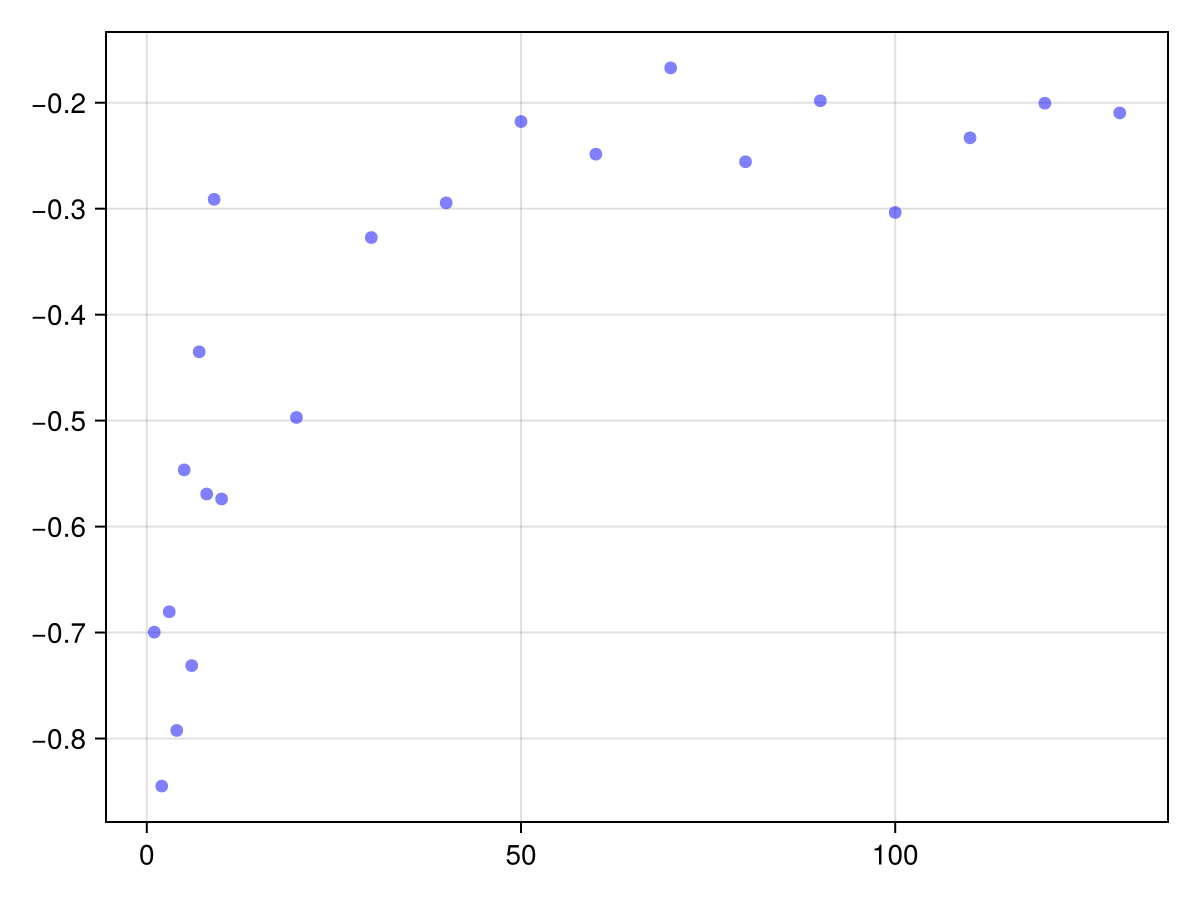

In [6]:
ks = sort(collect(keys(history.scores)))
fig = Figure()
ax = Axis(fig[1, 1])

mean_rewards = []
for k in ks
    best_sc = argmax(history.scores[k])
    best_params = history.params[k][best_sc]
    pol, V = optimize(best_params, softmax_functions)
    pol = to_gym_pol(pol);
    mean_rew = sepsis_gym.evaluate_policy(pol, 50000)
    push!(mean_rewards, mean_rew)
end

plot!(ax, ks, mean_rewards, color="blue", alpha=0.5)

# ax.xscale = log2
fig


In [8]:

function save_file(self::Any, name::String)
    # Implement saving to file, e.g., using Serialization
    open(name, "w") do io
        serialize(io, self)
    end
end


save_file (generic function with 1 method)

In [9]:
save_file(mean_rewards, "data/mcmc/mean_rewards.jld")

In [6]:
histories = [load_history("data/mcmc/history-$(i).jld") for i in 1:10];

UndefVarError: UndefVarError: `deserialize` not defined

In [16]:

fig = Figure()
ax = Axis(fig[1, 1])

for i in 1:10
    history = histories[i]
    ks = sort(collect(keys(history.mean_rewards)))
    plot!(ax, ks, [history.mean_rewards[k] for k in ks], alpha=0.5, color="blue")
end

ax.xscale = log2
fig


UndefVarError: UndefVarError: `histories` not defined

In [15]:
histories = [load_history("data/mcmc/history-linear-150-$(i).jld") for i in 1:10];


Any[11, 22, 33, 44, 55, 66]
Any[11, 22, 33, 44, 55, 66]
Any[11, 22, 33, 44, 55, 66]
Any[11, 22, 33, 44, 55, 66]
Any[11, 22, 33, 44, 55]
Any[11, 22, 33, 44, 55]
Any[11, 22, 33, 44, 55]
Any[11, 22, 33, 44, 55]
Any[11, 22, 33, 44, 55]
Any[11, 22, 33, 44, 55]


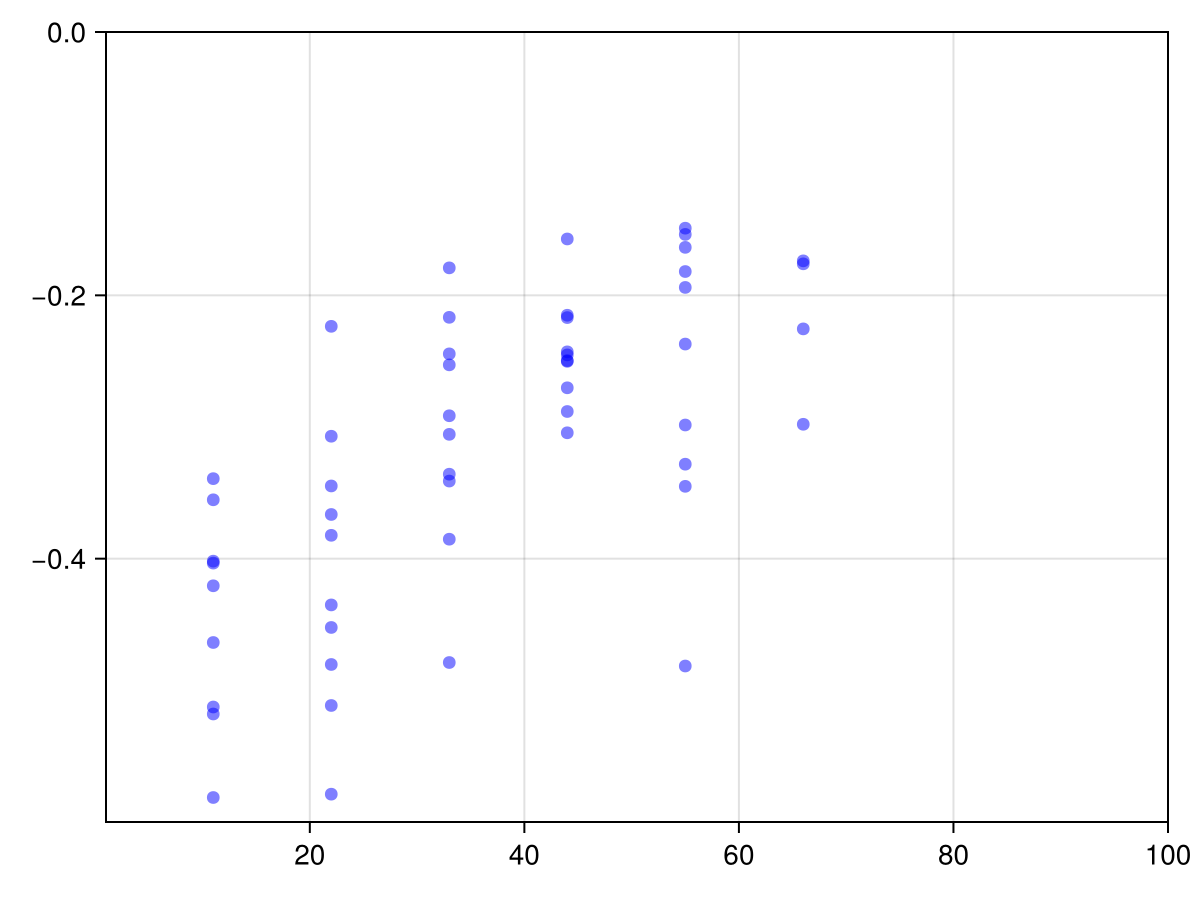

In [18]:
fig = Figure()
ax = Axis(fig[1, 1])

for i in 1:10
    history = histories[i]
    ks = sort(collect(keys(history.mean_rewards)))
    println(ks)
    plot!(ax, ks, [history.mean_rewards[k] for k in ks], alpha=0.5, color="blue")
end
xlims!(ax, 1, 100)
ylims!(ax, -0.6, 0)


# ax.xscale = log10
fig


In [ ]:

# rewards=Dict()

for i in 3:7
    history = histories[i]
    ks = sort(collect(keys(history.mean_rewards)))
    rewards[i] = []
    for k in ks
        best_params = history.params[k][argmax(history.scores[k])]
        pol, V = optimize(best_params, softmax_functions)
        reward = sepsis_gym.evaluate_policy(to_gym_pol(pol), 100000)
        push!(rewards[i], reward)
    end

end

ax.xscale = log10
fig


In [ ]:
rewards

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1])

for i in 1:2
    ks = sort(collect(keys(histories[i].mean_rewards)))
    # plot!(ax, ks, [history.mean_rewards[k] for k in ks], alpha=0.5, color="blue")
    plot!(ax, ks, rewards[i], alpha=0.5, color="blue")
end

ax.xscale = log10
fig


In [51]:
# policy = sepsis_gym.random_policy()
# episode = sepsis_gym.run_episode(policy)

In [ ]:
to_state(episode.visited[1])


In [ ]:
beliefs = get_beliefs()
init_state = to_state(sepsis_gym.random_initial_state())
states, rewards = simulate_episode(beliefs, to_policy(policy), init_state)
rewards

get_reward(states[end])

In [ ]:
to_state(episode.visited[1])

State(NORMAL, LOW, LOW, SUPER_HIGH, false, false, false, false)

In [ ]:
println("Checking if the actions in the episode are consistent with the state transitions")
for (i, state) in enumerate(episode.visited[1:end-1])
    action = to_action(policy[state])
    next_state = to_state(episode.visited[i+1])
    println(action.abx == next_state.abx && action.vaso == next_state.vaso && action.vent == next_state.vent)
end

In [ ]:
env_params = get_beliefs()
param_vector = get_env_params(env_params)


In [ ]:
policy = sepsis_gym.random_policy()
sepsis_gym.run_episode(policy).rewards

env = sepsis_gym.SepsisEnv(param_vector)

training = sepsis_gym.train_dqn(true_env, 10000, "test_call_from_julia")
training.evaluate_policy(10000)

UndefVarError: UndefVarError: `param_vector` not defined

In [ ]:
random_policies = [sepsis_gym.random_policy() for i in 1:100];

In [ ]:
sepsis_gym.run_episode(random_policies[1]).visited


2-element Vector{Tuple{Int64, Int64, Int64, Int64, Vararg{Bool, 4}}}:
 (-1, -1, 0, 1, 0, 0, 0, 0)
 (-1, -1, 0, 1, 0, 0, 0, 0)

In [ ]:
# param_vector = get_env_params(traces[end][:beliefs])

# env = sepsis_gym.SepsisEnv(param_vector)

# training = sepsis_gym.train_dqn(env, 100000, "thompson_sampling_try1")


In [ ]:
# training.evaluate_policy(10000)

In [ ]:

state = State(NORMAL, LOW, NORMAL, NORMAL, false, false, false, false)
deterministic_params = EnvParameters([1 for _ in 1:length(fieldnames(EnvParameters))]...)
policy = to_policy(sepsis_gym.random_policy())
next_state = get_next_state(deterministic_params, state, policy[state])
trace, sc = generate(get_next_state, (deterministic_params, state, Action(0, 0, 0)))

states, rewards = simulate_episode(deterministic_params, policy, state)
states

11-element Vector{State}:
 State(NORMAL, LOW, NORMAL, NORMAL, false, false, false, false)
 State(NORMAL, LOW, NORMAL, HIGH, false, true, false, true)
 State(HIGH, LOW, LOW, SUPER_HIGH, false, true, false, false)
 State(HIGH, LOW, NORMAL, SUPER_HIGH, false, true, false, false)
 State(HIGH, LOW, NORMAL, HIGH, false, false, false, false)
 State(NORMAL, LOW, NORMAL, NORMAL, false, true, false, true)
 State(HIGH, LOW, NORMAL, HIGH, false, false, false, true)
 State(NORMAL, LOW, LOW, SUPER_HIGH, false, true, false, false)
 State(HIGH, LOW, NORMAL, SUPER_HIGH, false, false, false, false)
 State(NORMAL, NORMAL, NORMAL, SUPER_HIGH, false, false, true, false)
 State(NORMAL, HIGH, LOW, HIGH, false, true, true, false)